# Notes - weighting recorded DS births

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

In [2]:
con = duckdb.connect("./data/us_births.db", read_only=True)

In [8]:
weighted_est_df = con.execute(
    """
    SELECT
        b.year,
        SUM (b.ds_case_weight) as case_weighted,
        SUM (b.p_ds_lb_wt) as year_prev_est,
        SUM (b.p_ds_lb_wt_mage) as year_age_prev_est,
        sum(e.prevalence / 10000.0) as year_ethn_prev_est,
        SUM (b.p_ds_lb_nt) as no_term_age_est,
        SUM (b.p_ds_lb_nt * (1 - r.reduction)) as term_under_est,
        SUM (b.down_ind) as down_ind,
    FROM
        us_births as b
        LEFT JOIN us_births_est_prevalence_ethnicity e
            ON b.year = e.year AND b.mracehisp_c = e.mracehisp_c
        LEFT JOIN reduction_rate_year r
            ON b.year = r.year
    WHERE
        b.year >= 1989
    GROUP BY
        b.year
    ORDER BY
        b.year
    """
).df()
weighted_est_df.to_csv(f"./output/us_births_weighted_ds_estimates_year.csv", index=False)
weighted_est_df

,year,case_weighted,year_prev_est,year_age_prev_est,year_ethn_prev_est,no_term_age_est,term_under_est,down_ind
0,1989,NaN,4199.429334,NaN,NaN,5435.804076,4201.805434,1954.0
1,1990,NaN,4391.877435,NaN,NaN,5716.629219,4394.402030,1983.0
2,1991,NaN,4432.223334,NaN,NaN,5794.837984,4433.762142,1791.0
3,1992,NaN,4407.190524,NaN,NaN,5888.002906,4408.741077,1816.0
4,1993,NaN,4376.943639,NaN,NaN,5957.920280,4378.555635,1763.0
5,1994,NaN,4360.531350,NaN,NaN,6063.337957,4361.998372,1706.0
6,1995,NaN,4375.276452,NaN,NaN,6140.807701,4376.564560,1640.0
7,1996,NaN,4280.466526,NaN,NaN,6279.330012,4281.998480,1677.0
8,1997,NaN,4365.985796,NaN,NaN,6396.586350,4367.179471,1663.0
9,1998,NaN,4481.738112,NaN,NaN,6598.625178,4483.180629,1682.0


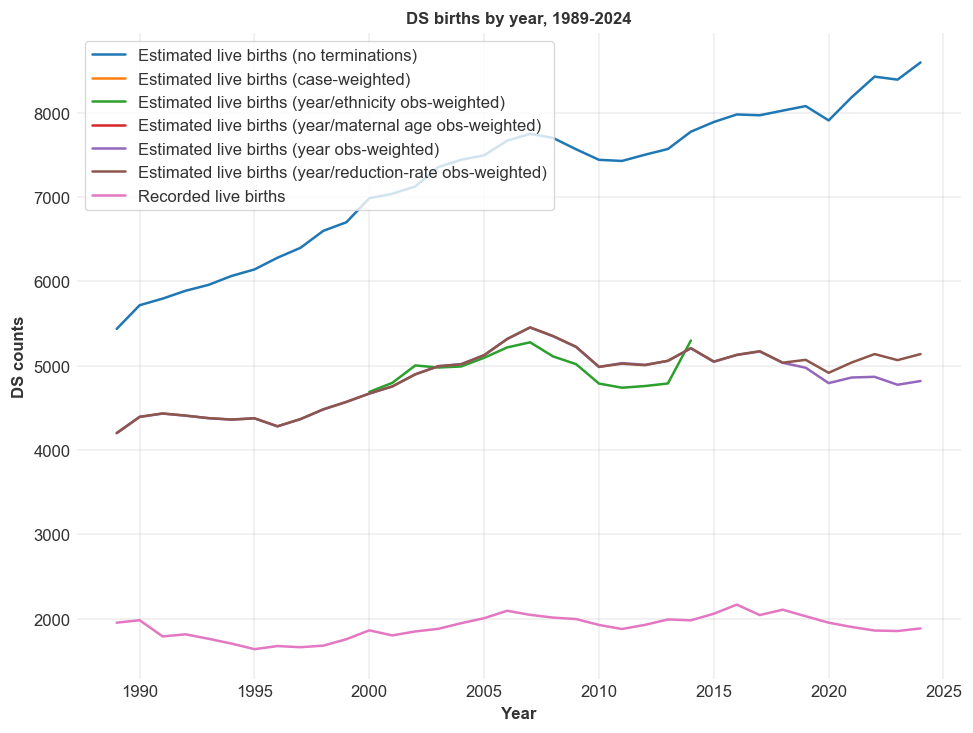

In [9]:
# plot by year
plt.figure(figsize=(8, 6))
plt.plot(weighted_est_df["year"], weighted_est_df["no_term_age_est"], label="Estimated live births (no terminations)")
plt.plot(weighted_est_df["year"], weighted_est_df["case_weighted"], label="Estimated live births (case-weighted)")
plt.plot(weighted_est_df["year"], weighted_est_df["year_ethn_prev_est"], label="Estimated live births (year/ethnicity obs-weighted)")
plt.plot(weighted_est_df["year"], weighted_est_df["year_age_prev_est"], label="Estimated live births (year/maternal age obs-weighted)")
plt.plot(weighted_est_df["year"], weighted_est_df["year_prev_est"], label="Estimated live births (year obs-weighted)")
plt.plot(weighted_est_df["year"], weighted_est_df["term_under_est"], label="Estimated live births (year/reduction-rate obs-weighted)")
plt.plot(weighted_est_df["year"], weighted_est_df["down_ind"], label="Recorded live births")
plt.title("DS births by year, 1989-2024")
plt.xlabel("Year")
plt.ylabel("DS counts")
plt.legend()

In [10]:
weighted_est_ages_df = con.execute(
    """
    SELECT
        b.mage_c,
        SUM (b.ds_case_weight) as case_weighted,
        SUM (b.p_ds_lb_wt) as year_prev_est,
        SUM (b.p_ds_lb_wt_mage) as year_age_prev_est,
        SUM (e.prevalence / 10000.0) as year_ethn_prev_est,
        SUM (b.p_ds_lb_nt) as no_term_age_est,
        SUM (b.p_ds_lb_nt * (1 - r.reduction)) as term_under_est,
        SUM (b.down_ind) as down_ind,
    FROM
        us_births as b
        LEFT JOIN us_births_est_prevalence_ethnicity e
            ON b.year = e.year AND b.mracehisp_c = e.mracehisp_c
        JOIN reduction_rate_year r
            ON b.year = r.year
    WHERE
        b.year >= 1989
    GROUP BY
        b.mage_c
    ORDER BY
        b.mage_c
    """
).df()
weighted_est_ages_df

,mage_c,case_weighted,year_prev_est,year_age_prev_est,year_ethn_prev_est,no_term_age_est,term_under_est,down_ind
0,10,NaN,0.144027,NaN,0.007811,0.088619,0.066471,0.0
1,11,NaN,0.473000,NaN,0.068694,0.282449,0.205734,0.0
2,12,NaN,6.550478,NaN,2.568642,3.689418,2.580493,2.0
3,13,NaN,42.703773,NaN,15.924328,24.230647,17.007112,7.0
4,14,NaN,217.172097,NaN,90.779089,122.848433,86.000604,39.0
5,15,NaN,699.278512,NaN,309.940027,394.728337,275.688307,163.0
6,16,NaN,1567.440186,NaN,732.857399,883.214695,615.226338,364.0
7,17,NaN,2760.999387,NaN,1341.544510,1554.139056,1079.562129,611.0
8,18,NaN,4340.608408,NaN,2192.129900,2438.841868,1687.403650,948.0
9,19,NaN,6140.474708,NaN,3180.107264,3446.865490,2373.471894,1389.0


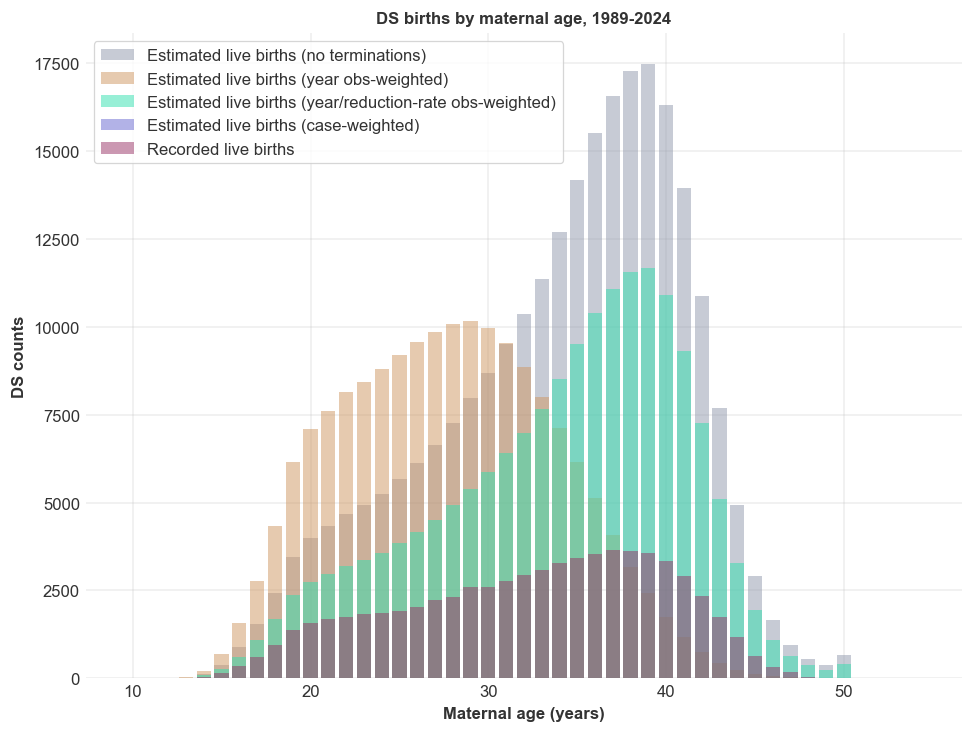

In [11]:
plt.figure(figsize=(8,6))
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["no_term_age_est"], color="#9098ac80", label="Estimated live births (no terminations)")
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["year_prev_est"], color="#cf966080", label="Estimated live births (year obs-weighted)")
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["term_under_est"], color="#30e0af80", label="Estimated live births (year/reduction-rate obs-weighted)")
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["case_weighted"], color="#6666d080", label="Estimated live births (case-weighted)")
plt.bar(weighted_est_ages_df["mage_c"], weighted_est_ages_df["down_ind"], color="#99336680", label="Recorded live births")
plt.title("DS births by maternal age, 1989-2024")
plt.xlabel("Maternal age (years)")
plt.ylabel("DS counts")
plt.legend()

In [30]:
ethnicity_df = con.execute(
    """
    SELECT
        b.mracehisp_c,
        SUM (b.ds_case_weight) as case_weighted,
        SUM (b.p_ds_lb_wt) as year_prev_est,
        SUM (b.p_ds_lb_wt_mage) as year_age_prev_est,
        SUM (e.prevalence / 10000.0) as year_ethn_prev_est,
        SUM (b.p_ds_lb_nt) as no_term_age_est,
        SUM (b.p_ds_lb_nt * (1 - r.reduction)) as term_under_est,
        SUM (b.down_ind) as down_ind,
    FROM
        us_births as b
        LEFT JOIN us_births_est_prevalence_ethnicity e
            ON b.year = e.year AND b.mracehisp_c = e.mracehisp_c
        JOIN reduction_rate_year r
            ON b.year = r.year
    WHERE
        b.year >= 1989
    GROUP BY
        b.mracehisp_c
    ORDER BY
        b.mracehisp_c
    """
).df().dropna()

race_labels = {
    1: "NH White",
    2: "NH Black",
    3: "AI/AN",
    4: "NH Asian/PI",
    5: "Hispanic"
}

ethnicity_df["mracehisp_c_label"] = ethnicity_df["mracehisp_c"].map(race_labels)

ethnicity_df

,mracehisp_c,case_weighted,year_prev_est,year_age_prev_est,year_ethn_prev_est,no_term_age_est,term_under_est,down_ind,mracehisp_c_label
0,1,85287.5049,84469.728875,84434.230971,47336.651345,128778.034270,88479.708436,38183.0,NH White
1,2,20178.3346,22177.994414,19459.702524,11706.958141,27705.765242,18972.346047,5487.0,NH Black
2,3,1235.6730,1363.331602,1144.868705,732.157731,1566.612363,1074.747722,553.0,AI/AN
3,4,4749.2172,6024.979192,6599.820234,2437.246189,11490.201593,7777.484841,1526.0,NH Asian/PI
4,5,43000.9038,37828.429982,28413.238702,22544.969565,51476.860291,34319.171858,14685.0,Hispanic


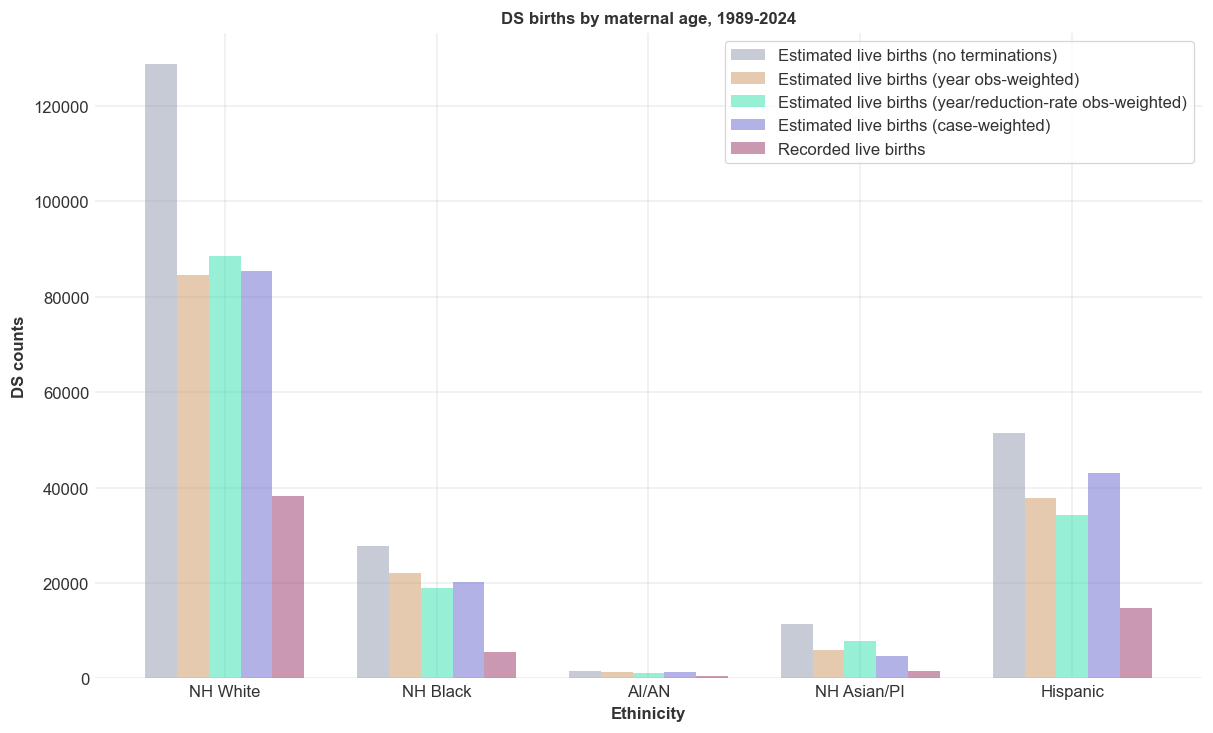

In [31]:
plt.figure(figsize=(10, 6))

x = ethnicity_df["mracehisp_c"]
labels = ethnicity_df["mracehisp_c_label"]

width = 0.15

plt.bar(x - 2*width, ethnicity_df["no_term_age_est"],
        width=width, color="#9098ac80",
        label="Estimated live births (no terminations)")

plt.bar(x - width, ethnicity_df["year_prev_est"],
        width=width, color="#cf966080",
        label="Estimated live births (year obs-weighted)")

plt.bar(x, ethnicity_df["term_under_est"],
        width=width, color="#30e0af80",
        label="Estimated live births (year/reduction-rate obs-weighted)")

plt.bar(x + width, ethnicity_df["case_weighted"],
        width=width, color="#6666d080",
        label="Estimated live births (case-weighted)")

plt.bar(x + 2*width, ethnicity_df["down_ind"],
        width=width, color="#99336680",
        label="Recorded live births")

plt.title("DS births by maternal age, 1989-2024")
plt.xlabel("Ethinicity")
plt.ylabel("DS counts")
plt.xticks(x, labels)
plt.legend()


In [32]:
ethnicity_2_df = con.execute(
    """
    SELECT
        b.mracehisp_c,
        SUM (b.ds_case_weight) as case_weighted,
        SUM (b.p_ds_lb_wt) as year_prev_est,
        SUM (b.p_ds_lb_wt_mage) as year_age_prev_est,
        SUM (e.prevalence / 10000.0) as year_ethn_prev_est,
        SUM (b.p_ds_lb_nt) as no_term_age_est,
        SUM (b.p_ds_lb_nt * (1 - r.reduction)) as term_under_est,
        SUM (b.down_ind) as down_ind,
    FROM
        us_births as b
        LEFT JOIN us_births_est_prevalence_ethnicity e
            ON b.year = e.year AND b.mracehisp_c = e.mracehisp_c
        JOIN reduction_rate_year r
            ON b.year = r.year
    WHERE
        b.year >= 2000 AND b.year <= 2014
    GROUP BY
        b.mracehisp_c
    ORDER BY
        b.mracehisp_c
    """
).df().dropna()

race_labels = {
    1: "NH White",
    2: "NH Black",
    3: "AI/AN",
    4: "NH Asian/PI",
    5: "Hispanic"
}

ethnicity_2_df["mracehisp_c_label"] = ethnicity_2_df["mracehisp_c"].map(race_labels)

ethnicity_2_df

,mracehisp_c,case_weighted,year_prev_est,year_age_prev_est,year_ethn_prev_est,no_term_age_est,term_under_est,down_ind,mracehisp_c_label
0,1,42243.4563,41508.168169,43106.911708,42164.188618,64506.817229,43895.618217,18402.0,NH White
1,2,10131.2173,10908.007539,9795.545279,10217.170426,13655.393722,9289.823049,2613.0,NH Black
2,3,643.6805,705.675358,593.296090,649.243114,785.391336,534.503694,258.0,AI/AN
3,4,1850.5577,2427.281721,2779.270600,1950.268220,4359.996471,2961.867065,602.0,NH Asian/PI
4,5,19501.0099,17629.425709,16309.444065,19563.987446,22850.589729,15551.490371,6400.0,Hispanic


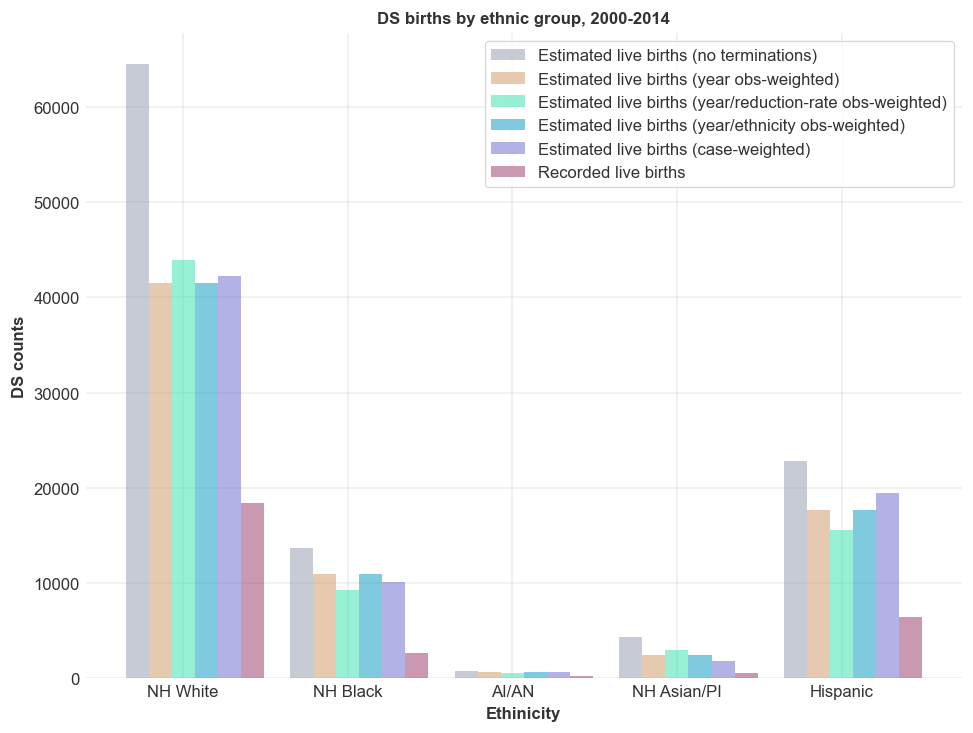

In [33]:
plt.figure(figsize=(8, 6))

x = ethnicity_2_df["mracehisp_c"]
labels = ethnicity_2_df["mracehisp_c_label"]

width = 0.14

plt.bar(x - 2*width, ethnicity_2_df["no_term_age_est"],
        width=width, color="#9098ac80",
        label="Estimated live births (no terminations)")

plt.bar(x - width, ethnicity_2_df["year_prev_est"],
        width=width, color="#cf966080",
        label="Estimated live births (year obs-weighted)")

plt.bar(x, ethnicity_2_df["term_under_est"],
        width=width, color="#30e0af80",
        label="Estimated live births (year/reduction-rate obs-weighted)")

plt.bar(x + width, ethnicity_2_df["year_prev_est"],
        width=width, color="#0096c080",
        label="Estimated live births (year/ethnicity obs-weighted)")

plt.bar(x + 2*width, ethnicity_2_df["case_weighted"],
        width=width, color="#6666d080",
        label="Estimated live births (case-weighted)")

plt.bar(x + 3*width, ethnicity_2_df["down_ind"],
        width=width, color="#99336680",
        label="Recorded live births")

plt.title("DS births by ethnic group, 2000-2014")
plt.xlabel("Ethinicity")
plt.ylabel("DS counts")
plt.xticks(x, labels)
plt.legend()


In [34]:
educ_df = con.execute(
    """
    SELECT
        b.meduc,
        SUM (b.ds_case_weight) as case_weighted,
        SUM (b.p_ds_lb_wt) as year_prev_est,
        SUM (b.p_ds_lb_wt_mage) as year_age_prev_est,
        SUM (e.prevalence / 10000.0) as year_ethn_prev_est,
        SUM (b.p_ds_lb_nt) as no_term_age_est,
        SUM (b.p_ds_lb_nt * (1 - r.reduction)) as term_under_est,
        SUM (b.down_ind) as down_ind,
    FROM
        us_births as b
        LEFT JOIN us_births_est_prevalence_ethnicity e
            ON b.year = e.year AND b.mracehisp_c = e.mracehisp_c
        JOIN reduction_rate_year r
            ON b.year = r.year
    WHERE
        b.year >= 2003
    GROUP BY
        b.meduc
    ORDER BY
        b.meduc
    """
).df().dropna()

meduc_labels = {
    1: "8th grade or less",
    2: "9th through 12th grade",
    3: "High school graduate",
    4: "Some college credit",
    5: "Associate degree",
    6: "Bachelor's degree",
    7: "Master's degree",
    8: "Doctorate or Professional Degree",
    9: "Unknown",
}

educ_df["meduc_label"] = educ_df["meduc"].map(meduc_labels)

educ_df

,meduc,case_weighted,year_prev_est,year_age_prev_est,year_ethn_prev_est,no_term_age_est,term_under_est,down_ind,meduc_label
0,1,7102.2331,3418.195636,2761.994511,2311.487749,6562.912352,4271.443497,2554.0,8th grade or less
1,2,9711.5718,9774.595485,5912.404240,6488.043318,10527.743716,6868.542511,3539.0,9th through 12th grade
2,3,20058.9144,22217.582955,12279.975393,12017.546827,25674.669609,16604.751812,7706.0,High school graduate
3,4,16320.1579,16948.069685,10511.601184,9411.763699,22286.078440,14434.750615,6420.0,Some college credit
4,5,7588.0273,6809.646779,4573.424635,3457.557467,11117.553908,7176.531642,3048.0,Associate degree
5,6,17177.3705,16880.704453,12560.590736,7997.746131,33060.669366,21307.433806,7033.0,Bachelor's degree
6,7,7460.0806,7546.208201,6255.721375,3379.892582,18171.357172,11662.468367,3066.0,Master's degree
7,8,1923.7196,2175.895914,2065.760134,910.036400,6422.781566,4120.292242,783.0,Doctorate or Professional Degree
8,9,1485.3722,1195.126319,838.571282,393.203646,2647.284361,1699.560778,565.0,Unknown


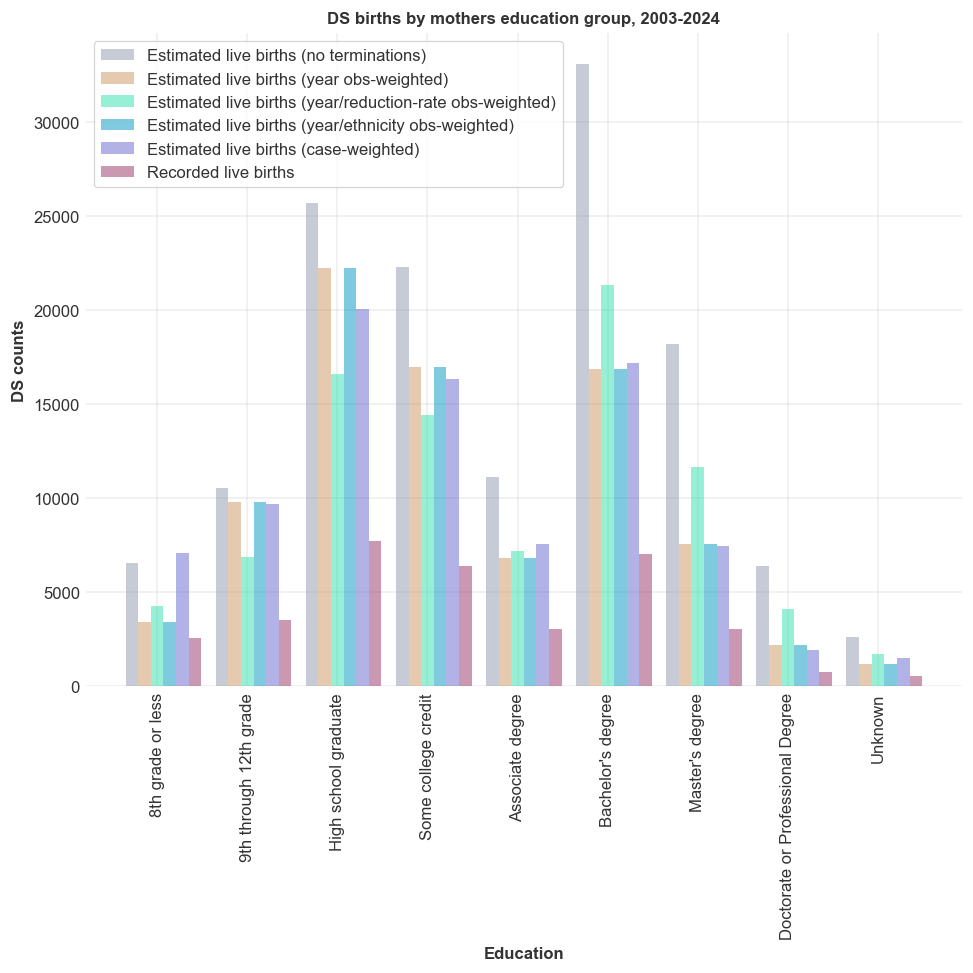

In [35]:
plt.figure(figsize=(8, 8))

x = educ_df["meduc"]
labels = educ_df["meduc_label"]

width = 0.14

plt.bar(x - 2*width, educ_df["no_term_age_est"],
        width=width, color="#9098ac80",
        label="Estimated live births (no terminations)")

plt.bar(x - width, educ_df["year_prev_est"],
        width=width, color="#cf966080",
        label="Estimated live births (year obs-weighted)")

plt.bar(x, educ_df["term_under_est"],
        width=width, color="#30e0af80",
        label="Estimated live births (year/reduction-rate obs-weighted)")

plt.bar(x + width, educ_df["year_prev_est"],
        width=width, color="#0096c080",
        label="Estimated live births (year/ethnicity obs-weighted)")

plt.bar(x + 2*width, educ_df["case_weighted"],
        width=width, color="#6666d080",
        label="Estimated live births (case-weighted)")

plt.bar(x + 3*width, educ_df["down_ind"],
        width=width, color="#99336680",
        label="Recorded live births")

plt.title("DS births by mothers education group, 2003-2024")
plt.xlabel("Education")
plt.ylabel("DS counts")
plt.xticks(x, labels, rotation=90)
plt.legend()


In [36]:
con.close()